# <span style="color:red">MODELING & EVALUATION</span>

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## <span style="color:blue">Data Preprocessing</span>

In [42]:
df.head()
# df["Previous campaign's outcome"].value_counts()

,Age,Type of job,Marital status,Education,Housing loan,Personal loan,Latest month,Latest day,Latest duration,Number of contacts,Passed days,Previous campaign's number,Previous campaign outcome,Label,Contact status,Age range,Latest duration range
0,56,housemaid,married,basic.4y,no,no,may,mon,261,1,-1,0,nonexistent,0,Never contacted,56-60,<06mins
1,57,services,married,high.school,no,no,may,mon,149,1,-1,0,nonexistent,0,Never contacted,56-60,<06mins
2,37,services,married,high.school,yes,no,may,mon,226,1,-1,0,nonexistent,0,Never contacted,36-40,<06mins
3,40,admin.,married,basic.6y,no,no,may,mon,151,1,-1,0,nonexistent,0,Never contacted,36-40,<06mins
4,56,services,married,high.school,no,yes,may,mon,307,1,-1,0,nonexistent,0,Never contacted,56-60,06-10mins


In [43]:
df.drop(columns=['Age range', 'Latest duration range'], inplace=True)

df['Housing loan'] = df['Housing loan'].replace({'yes': 1, 'no': 0}).astype('Int64')

df['Personal loan'] = df['Personal loan'].replace({'yes': 1, 'no': 0}).astype('Int64')

df['Contact status'] = df['Contact status'].apply(lambda x: 0 if x == 'Never contacted' else 1)

In [44]:
temp, test = train_test_split(df, test_size=0.3, random_state=60)
train, val = train_test_split(temp, test_size=0.3, random_state=60)

print(f'train: {train.shape[0]} rows')
print(f'val: {val.shape[0]} rows')
print(f'test: {test.shape[0]} rows')

train: 18734 rows
val: 8029 rows
test: 11471 rows


### Feature selection (Woe & IV)

In [45]:
def calculate_woe_iv(df_name, feature, Label):
    # Nhóm theo từng giá trị (hoặc bin) của feature
    woe_dfm = df_name.groupby(feature)[Label].agg(['count', 'sum']).reset_index()
    woe_dfm.columns = [feature, 'Total', 'Event']
    woe_dfm['NonEvent'] = woe_dfm['Total'] - woe_dfm['Event']
    # Tổng số lượng event / nonevent
    event_total = woe_dfm['Event'].sum()
    nonevent_total = woe_dfm['NonEvent'].sum()
    # Tính WOE và IV
    woe_dfm['%Event'] = (woe_dfm['Event'] / event_total).replace(0, 1e-8)
    woe_dfm['%NonEvent'] = (woe_dfm['NonEvent'] / nonevent_total).replace(0, 1e-8)
    woe_dfm['WOE'] = np.log(woe_dfm['%Event'].replace(0, 1e-8) / woe_dfm['%NonEvent'])
    woe_dfm['IV'] = (woe_dfm['%Event'] - woe_dfm['%NonEvent']) * woe_dfm['WOE']
    IV_total = woe_dfm['IV'].sum()
    return IV_total

feature_list = [col for col in train.columns if col != 'Label']
ivtotal_results = []

for feature in feature_list:
    ivtotal = calculate_woe_iv(train, feature, 'Label')
    ivtotal_results.append({'Feature': feature, 'IV Importance Score': ivtotal})

ivtotal_table = pd.DataFrame(ivtotal_results).sort_values(by='IV Importance Score', ascending=False)
print(ivtotal_table)

                       Feature  IV Importance Score
8              Latest duration             6.103402
10                 Passed days             0.566659
13              Contact status             0.522121
12   Previous campaign outcome             0.517654
6                 Latest month             0.476739
11  Previous campaign's number             0.311059
0                          Age             0.250470
1                  Type of job             0.158783
9           Number of contacts             0.149583
3                    Education             0.036557
2               Marital status             0.022964
4                 Housing loan             0.004836
7                   Latest day             0.003060
5                Personal loan             0.000194


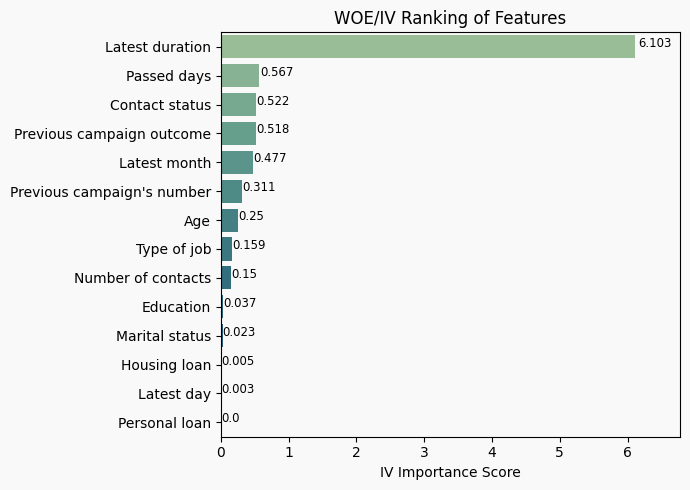

In [46]:
featurechart(ivtotal_table, 'IV Importance Score', 'Feature', 'WOE/IV Ranking of Features')

- **IV Total > 0.3**: Latest duration, Passed days, Contact status, Previous campaign outcome, Latest month, Previous campaign's number  
- **0.1 < IV Total < 0.3**: Age, Type of job, Number of contacts  
- **0.02 < IV Total < 0.1**: Education, Marital status   
- **IV Total < 0.02**: Housing loan, Latest day, Personal loan

**Latest duration (too high IV Total)**: Latest Call Duration emerged as the most important feature. This makes sense, as longer calls may indicate higher customer interest. However, this feature poses a data leakage risk in real-world prediction scenarios prior to the call

In [47]:
# Data for Logistic Regression (LR)
trainLR = train.copy()
valLR = val.copy()
testLR = test.copy()

for data in [trainLR, valLR, testLR]:
    data.drop(columns=['Latest duration', 'Latest day', 'Personal loan', 'Housing loan'], inplace=True)

trainLR.columns

Index(['Age', 'Type of job', 'Marital status', 'Education', 'Latest month',
       'Number of contacts', 'Passed days', 'Previous campaign's number',
       'Previous campaign outcome', 'Label', 'Contact status'],
      dtype='object')

In [48]:
# Data for Decision Tree (DT)
trainDT = train.copy()
valDT = val.copy()
testDT = test.copy()

for data in [trainDT, valDT, testDT]:
    data.drop(columns=['Latest duration'], inplace=True)

trainDT.columns

Index(['Age', 'Type of job', 'Marital status', 'Education', 'Housing loan',
       'Personal loan', 'Latest month', 'Latest day', 'Number of contacts',
       'Passed days', 'Previous campaign's number',
       'Previous campaign outcome', 'Label', 'Contact status'],
      dtype='object')

## <span style="color:blue">Data Transformation</span>

### WOE Coding for Logistic Regression

In [49]:
trainLR.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18734 entries, 10024 to 32590
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age                         18734 non-null  int64 
 1   Type of job                 18734 non-null  object
 2   Marital status              18734 non-null  object
 3   Education                   18734 non-null  object
 4   Latest month                18734 non-null  object
 5   Number of contacts          18734 non-null  int64 
 6   Passed days                 18734 non-null  int64 
 7   Previous campaign's number  18734 non-null  int64 
 8   Previous campaign outcome   18734 non-null  object
 9   Label                       18734 non-null  Int64 
 10  Contact status              18734 non-null  int64 
dtypes: Int64(1), int64(5), object(5)
memory usage: 1.7+ MB


In [50]:
categorical_cols = ['Type of job', 'Marital status', 'Education', 
                    'Latest month', "Previous campaign outcome"]

def get_woe_map(df, feature, label):
    df_woe = df.groupby(feature)[label].agg(['count', 'sum']).reset_index()
    df_woe.columns = [feature, 'Total', 'Event']
    df_woe['NonEvent'] = df_woe['Total'] - df_woe['Event']
    event_total = df_woe['Event'].sum()
    nonevent_total = df_woe['NonEvent'].sum()
    df_woe['%Event'] = (df_woe['Event'] / event_total).replace(0, 1e-8)
    df_woe['%NonEvent'] = (df_woe['NonEvent'] / nonevent_total).replace(0, 1e-8)
    df_woe['WOE'] = np.log(df_woe['%Event'] / df_woe['%NonEvent'])
    return df_woe[[feature, 'WOE']].set_index(feature)['WOE'].to_dict()

for col in categorical_cols:
    woe_map = get_woe_map(trainLR, col, 'Label')
    for data in [trainLR, valLR, testLR]:
        data[f'{col}_WOE'] = data[col].map(woe_map)

trainLR.drop(columns=categorical_cols, inplace=True)
valLR.drop(columns=categorical_cols, inplace=True)
testLR.drop(columns=categorical_cols, inplace=True)

In [51]:
print(trainLR.info())
print(valLR.info())
print(testLR.info())

<class 'pandas.core.frame.DataFrame'>
Index: 18734 entries, 10024 to 32590
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            18734 non-null  int64  
 1   Number of contacts             18734 non-null  int64  
 2   Passed days                    18734 non-null  int64  
 3   Previous campaign's number     18734 non-null  int64  
 4   Label                          18734 non-null  Int64  
 5   Contact status                 18734 non-null  int64  
 6   Type of job_WOE                18734 non-null  float64
 7   Marital status_WOE             18734 non-null  float64
 8   Education_WOE                  18734 non-null  float64
 9   Latest month_WOE               18734 non-null  float64
 10  Previous campaign outcome_WOE  18734 non-null  float64
dtypes: Int64(1), float64(5), int64(5)
memory usage: 1.7 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 80

In [52]:
X_trainLR = trainLR.drop("Label", axis=1)
y_trainLR = trainLR["Label"]

X_valLR = valLR.drop("Label", axis=1)
y_valLR = valLR["Label"]

X_testLR = testLR.drop("Label", axis=1)
y_testLR = testLR["Label"]

scaler = StandardScaler()
scaler_trainLR = scaler.fit(X_trainLR)

X_trainLR_scaled = scaler_trainLR.transform(X_trainLR)
X_valLR_scaled = scaler_trainLR.transform(X_valLR)
X_testLR_scaled = scaler_trainLR.transform(X_testLR)

### One-hot Encoding for Decision Tree

In [53]:
trainDT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18734 entries, 10024 to 32590
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age                         18734 non-null  int64 
 1   Type of job                 18734 non-null  object
 2   Marital status              18734 non-null  object
 3   Education                   18734 non-null  object
 4   Housing loan                18734 non-null  Int64 
 5   Personal loan               18734 non-null  Int64 
 6   Latest month                18734 non-null  object
 7   Latest day                  18734 non-null  object
 8   Number of contacts          18734 non-null  int64 
 9   Passed days                 18734 non-null  int64 
 10  Previous campaign's number  18734 non-null  int64 
 11  Previous campaign outcome   18734 non-null  object
 12  Label                       18734 non-null  Int64 
 13  Contact status              18734 non-null  int

In [54]:
def onehot_encoding(data):
    categorical_cols = ['Type of job', 'Marital status', 'Education', 'Latest month', 'Latest day', 
                       "Previous campaign outcome"]
    for col in categorical_cols:
        dummies = pd.get_dummies(data[col], prefix=col.replace(' ', ''), prefix_sep='_', drop_first=False).astype(int)
        data = pd.concat([data, dummies], axis=1)
        data.drop(columns=col, inplace=True)
    return data

trainDT = onehot_encoding(trainDT)
valDT = onehot_encoding(valDT)
testDT = onehot_encoding(testDT)

In [55]:
trainDT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18734 entries, 10024 to 32590
Data columns (total 47 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   Age                                  18734 non-null  int64
 1   Housing loan                         18734 non-null  Int64
 2   Personal loan                        18734 non-null  Int64
 3   Number of contacts                   18734 non-null  int64
 4   Passed days                          18734 non-null  int64
 5   Previous campaign's number           18734 non-null  int64
 6   Label                                18734 non-null  Int64
 7   Contact status                       18734 non-null  int64
 8   Typeofjob_admin.                     18734 non-null  int64
 9   Typeofjob_blue-collar                18734 non-null  int64
 10  Typeofjob_entrepreneur               18734 non-null  int64
 11  Typeofjob_housemaid                  18734 non-null  in

In [56]:
X_trainDT = trainDT.drop("Label", axis=1)
y_trainDT = trainDT["Label"]

X_valDT = valDT.drop("Label", axis=1)
y_valDT = valDT["Label"]

X_testDT = testDT.drop("Label", axis=1)
y_testDT = testDT["Label"]

## <span style="color:blue">Modeling 1: Logistic Regression</span>

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [58]:
modelLR = LogisticRegression(class_weight='balanced')

modelLR.fit(X_trainLR_scaled, y_trainLR)

y_predLR = modelLR.predict(X_valLR_scaled)

print(confusion_matrix(y_valLR, y_predLR))
print(classification_report(y_valLR, y_predLR))

[[6114 1039]
 [ 431  445]]
              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89      7153
         1.0       0.30      0.51      0.38       876

    accuracy                           0.82      8029
   macro avg       0.62      0.68      0.63      8029
weighted avg       0.86      0.82      0.84      8029



In [59]:
y_predLR = modelLR.predict(X_testLR_scaled)
accuracyLR = accuracy_score(y_testLR, y_predLR)

print('--- Logistic Regression – Training Results ---')
print(f"accuracy score: {accuracyLR:.4f}")
print(confusion_matrix(y_testLR, y_predLR))
print(classification_report(y_testLR, y_predLR))

--- Logistic Regression – Training Results ---
accuracy score: 0.8150
[[8685 1514]
 [ 608  664]]
              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89     10199
         1.0       0.30      0.52      0.38      1272

    accuracy                           0.82     11471
   macro avg       0.62      0.69      0.64     11471
weighted avg       0.86      0.82      0.84     11471



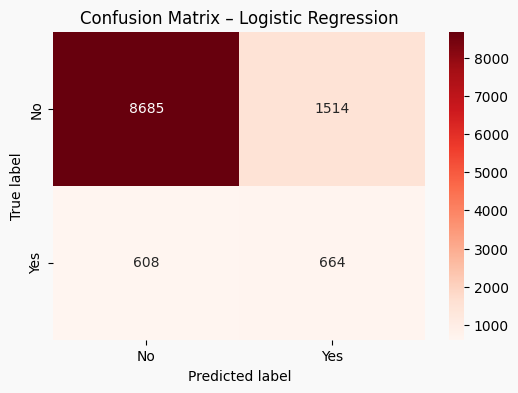

In [60]:
cmLR = confusion_matrix(y_testLR, y_predLR)
confusionmatrix(cmLR, 'Logistic Regression')

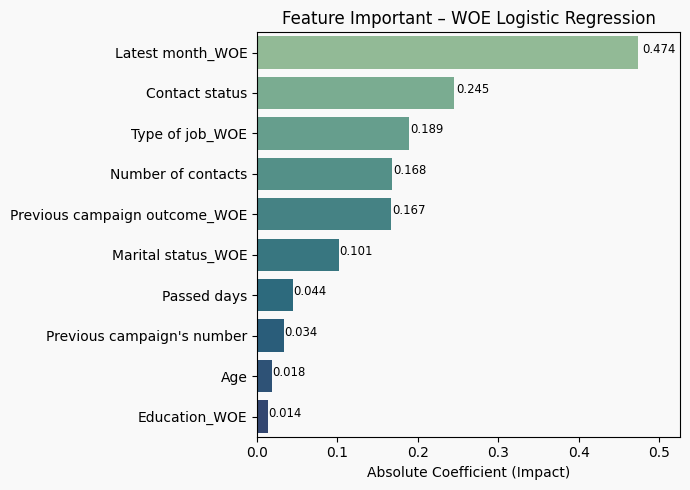

In [61]:
coefs = modelLR.coef_[0]
feature_names = X_testLR.columns
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs,
    'Absolute Coefficient (Impact)': np.abs(coefs)
}).sort_values(by='Absolute Coefficient (Impact)', ascending=False)

featurechart(feat_imp, 'Absolute Coefficient (Impact)', 'Feature', 'Feature Important – WOE Logistic Regression')

## <span style="color:blue">Modeling 2: Decision Tree</span>

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree

In [63]:
modelDT = DecisionTreeClassifier(criterion='entropy', max_depth=12, random_state=40, class_weight='balanced')
modelDT.fit(X_trainDT, y_trainDT)

y_valDT_pred = modelDT.predict(X_valDT)

print(confusion_matrix(y_valDT, y_valDT_pred))
print(classification_report(y_valDT, y_valDT_pred))

[[6573  580]
 [ 516  360]]
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92      7153
         1.0       0.38      0.41      0.40       876

    accuracy                           0.86      8029
   macro avg       0.66      0.66      0.66      8029
weighted avg       0.87      0.86      0.87      8029



In [64]:
y_predDT = modelDT.predict(X_testDT)
accuracyDT = accuracy_score(y_testDT, y_predDT)

print('--- Decision Tree – Training Results ---')
print(f"accuracy score: {accuracyDT:.4f}")
print(confusion_matrix(y_testDT, y_predDT))
print(classification_report(y_testDT, y_predDT))

--- Decision Tree – Training Results ---
accuracy score: 0.8596
[[9318  881]
 [ 730  542]]
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92     10199
         1.0       0.38      0.43      0.40      1272

    accuracy                           0.86     11471
   macro avg       0.65      0.67      0.66     11471
weighted avg       0.87      0.86      0.86     11471



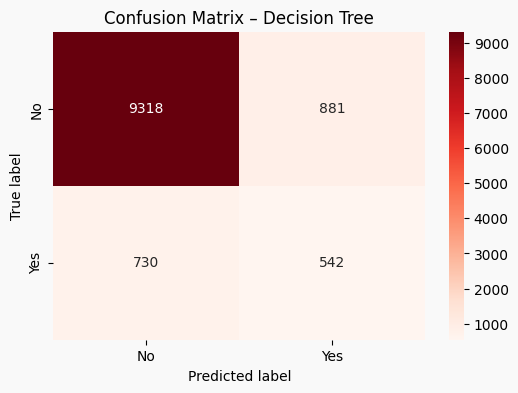

In [65]:
cmDT = confusion_matrix(y_testDT, y_predDT)
confusionmatrix(cmDT, 'Decision Tree')

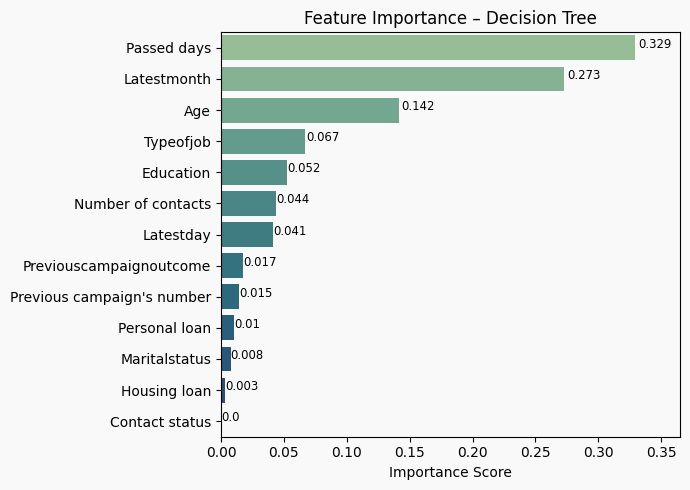

In [66]:
importances = modelDT.feature_importances_

feature_names = X_testDT.columns
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance Score': importances})

feat_df['Group'] = feat_df['Feature'].str.split('_').str[0]

grouped = feat_df.groupby('Group', as_index=False)['Importance Score'].sum().sort_values(by='Importance Score', ascending=False)

featurechart(grouped, 'Importance Score', 'Group', 'Feature Importance – Decision Tree')

## <span style="color:blue">Model Evaluation</span>

### ROC Curve

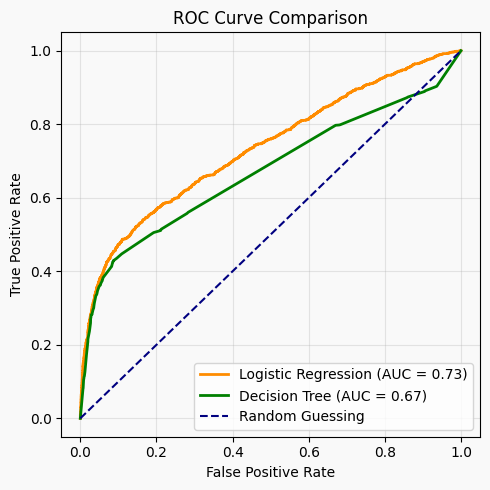

In [67]:
from sklearn.metrics import roc_curve, auc

y_prob_LR = modelLR.predict_proba(X_testLR_scaled)[:, 1]
y_prob_DT = modelDT.predict_proba(X_testDT)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_testLR, y_prob_LR)
fpr_dt, tpr_dt, _ = roc_curve(y_testDT, y_prob_DT)

auc_lr = auc(fpr_lr, tpr_lr)
auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(5,5))
plt.plot(fpr_lr, tpr_lr, color='darkorange', linewidth=2, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_dt, tpr_dt, color='green', linewidth=2, label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guessing')
plt.gcf().set_facecolor('#f9f9f9')
plt.gca().set_facecolor('#f9f9f9')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Model performance summary

In [68]:
# F1-score
f1_lr = f1_score(y_testLR, y_predLR)
f1_dt = f1_score(y_testDT, y_predDT)

# Precision
precision_lr = precision_score(y_testLR, y_predLR, pos_label=1.0)
precision_dt = precision_score(y_testDT, y_predDT, pos_label=1.0)

# Recall
recall_lr = recall_score(y_testLR, y_predLR, pos_label=1.0)
recall_dt = recall_score(y_testDT, y_predDT, pos_label=1.0)

metric_valuation = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'], 
                           'Logistic Regression': [round(accuracyLR, 4), round(precision_lr, 4), round(recall_lr, 4), 
                                                   round(f1_lr, 4), round(auc_lr, 4)],
                           'Decision Tree': [round(accuracyDT, 4), round(precision_dt, 4), round(recall_dt, 4), 
                                             round(f1_dt, 4), round(auc_dt, 4)]})
metric_valuation.set_index('Metric', inplace=True)

metric_valuation

,Logistic Regression,Decision Tree
Metric,,
Accuracy,0.8150,0.8596
Precision,0.3049,0.3809
Recall,0.5220,0.4261
F1-score,0.3849,0.4022
AUC,0.7342,0.6724
